# Psychedelic Bunny Rabbit

Using Neural Style Transfer with Pytorch.


First let's define our actors:

- **content** is the original image, to which we will apply the style transfer
- **style** is the image from which we want to take the style
- **target** is the target image, the result of the transfer

The style transfer is based on findind three losses:

- content loss
- style loss
- target loss

Style and content are not optimized, and their loss is calculated using the current target iteration and checking the differences between them. The target loss is the final loss, and it's calculated using as parameters both content and style loss.

It's absolutely neccesary to have a pretrained model, as we need to reuse it's layers (which we now that have a good feature extraction).

In [ ]:
from tqdm import tqdm
import cv2
from IPython.display import clear_output
from time import sleep
import numpy as np
import glob
from PIL import Image
from time import time
import matplotlib.pyplot as plt
from torch.nn import Sequential
import torch
import torch.optim as optim
from torchvision import transforms as T
from torchvision import models

In [ ]:
!rm -rf sample_data/
import os
if not os.path.isdir('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
# Define constants

imsize = 512

# image normalization
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# paths
styles_path = 'drive/My Drive/psychedelic_bunny_rabbit/styles'
original_path = 'drive/My Drive/psychedelic_bunny_rabbit/original.jpg'
target_path = 'drive/My Drive/psychedelic_bunny_rabbit'

# torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VGG Layers Extraction

We will use the VGG features. We won't be needing the classification behavior.

We need to freeze all parameters, as we'll be optimizing the target image only.

We won't be using all the layers, only a part (off).

In [4]:
off = 14

vgg = models.vgg16(pretrained=True).features[:off]
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
)


## Input output processing

Functions to convert an image to a tensor and viceversa.

In [ ]:
def to_tensor(im):
  transform = T.Compose([
    T.Resize((imsize, imsize)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
  ])
  tensor = transform(im)
  tensor = tensor[:3,:,:].unsqueeze(0)
  tensor = tensor.to(device)
  return tensor

def to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image


## Feature extraction per picture

We need to define the layers we'll use as representation both for content and style.

The content representation layer will be the second-to-last.

As style representation we'll use all layers, each one of them will have a corresponding weight to perform the total style loss.

Our feature concept will be dict which joins the conv layer name with the output of that layer.

In [6]:
# first, let's extract the names of all the convolutional layers
conv_layers = [name for name, layer in vgg._modules.items() 
               if layer.__class__.__name__ == 'Conv2d']
conv_layers

['0', '2', '5', '7', '10', '12']

In [7]:
# the content representation is the second to last layer
content_representation = conv_layers[-2]
content_representation

'10'

In [ ]:
def get_features(tensor, model):
    features = {}
    x = tensor

    for i, layer in model._modules.items():
        x = layer(x)
        if i in conv_layers:
            features[i] = x
            
    return features

## Style weights

The style weights will defined with an exponential distribution, starting with high values for the first layers and decrease the value for the last layers.

We give higher weights to earlier layers, as this gives us larger style artifacts. Also, we will exclude from this layers the content representation layer.

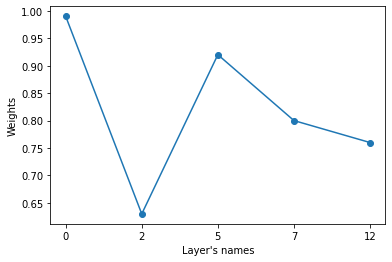

In [9]:
style_weights = list(np.random.randint(low=40, high=100, size=len(conv_layers))/100)
style_weights = dict(zip(conv_layers, style_weights))
del style_weights[content_representation]

out = style_weights
f, ax = plt.subplots(1)
ax.scatter(list(out.keys()), list(out.values()))
ax.plot(list(out.keys()), list(out.values()))
ax.set_ylabel('Weights')
ax.set_xlabel('Layer\'s names')
plt.show()

## Gramian matrix

Quoting [wikipedia](https://en.wikipedia.org/wiki/Gramian_matrix), the Gramian matrix is used to compute the linear independence - the matrix linear independence depends on wether the Gram determinant is non zero.

We need to find the gramian matrix for every layer of our style representation, as this matrices will give us the feature correlations between the different filter responses. This will allow us to capture the texture information, as stated in [Gatys Image Style Transfer Paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf):

>>
To obtain a representation of the style of an input image, we use a feature space designed to capture texture information [10]. This feature space can be built on top of the filter responses in any layer of the network. It consists of the cor- relations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix.
>>

### Gram matrix by *layer*

$$ G^l_{ji} = \sum_{k} {(F^l_{ik} * F^l_{jk})} $$

In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

## Losses

### Total loss
We need to define **original content** and **style** weights to perform the total loss:

$$ \mathcal{L}_{total} = \alpha * \mathcal{L}_{content} + \beta * \mathcal{L}_{style} $$

Where $\alpha$ and $\beta$ are the content and style weights.

### Content loss

The content loss is simply the the mean diff between the target features and the real content features.

### Style loss

This loss is a little bit more complex, it's based in find the loss for every layer using the mean diff (same as content loss), but the final style loss is the result of:

$$ \mathcal{L}_{style} = \sum \mathcal{W_{layer}} * \mathcal{L_{layer}} $$

Where ${\mathcal{W_{layer}}}$ is the defined weight per layer (using the exponential distribution) and $\mathcal{L}_{layer}$ the loss of each layer.

$\mathcal{L}_{style}$ is divided by $(\mathcal{d} * \mathcal{w} * \mathcal{h})$ which is the target feature shape.

In [ ]:
# content and style weights
alpha = 1
beta = 1e6

# losses
def get_content_loss(content_features, target_features):
  feat = (target_features[content_representation] - content_features[content_representation])
  return torch.mean(feat**2)

def get_style_loss(style_grams, target_features):
  # initialize the style loss to 0
  style_loss = 0
  # then add to it for each layer's gram matrix loss
  for layer in style_weights:
      # get the "target" style representation for the layer
      target_feature = target_features[layer]
      target_gram = gram_matrix(target_feature)
      _, d, h, w = target_feature.shape
      # get the "style" style representation
      style_gram = style_grams[layer]
      # the style loss for one layer, weighted appropriately
      layer_style_loss = torch.mean((target_gram - style_gram)**2)
      layer_style_loss = style_weights[layer] * layer_style_loss
      # add to the style loss
      style_loss += layer_style_loss / (d * h * w)
  return style_loss

def get_total_loss(content_loss, style_loss):
  return alpha * content_loss + beta * style_loss

## Style transfer

Let's define a function to perform the Style Transfer given a content and a style.


In [ ]:
def transfer(content, style, model, steps,
             show_every, lr, show_size):
  # init the content tensor and its features
  content_tensor = to_tensor(content)
  content_features = get_features(content_tensor, model)

  # init the target tensor
  # will require grad as it will be optimized
  target = content_tensor.clone().requires_grad_(True).to(device)

  # create the style tensor and its gram features
  style_tensor = to_tensor(style)
  style_features = get_features(style_tensor, vgg)
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  # create optimizer
  optimizer = optim.Adam([target], lr=lr)

  # create figure
  fig, ax = plt.subplots(1)
  ax_img = ax.imshow(np.zeros(show_size))
  fig.show()
  fig.canvas.draw()

  for step in range(1, steps+1):

    # get the features from the target
    target_features = get_features(target, model)

    # compute the batch loss
    content_loss = get_content_loss(content_features, target_features)
    style_loss = get_style_loss(style_grams, target_features)
    total_loss = get_total_loss(content_loss, style_loss)

    # optimize target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if step % show_every == 0:
      print(f'step: {step} - total_loss: {total_loss.item()}')
      clear_output()
      target_image = to_image(target)
      target_image = cv2.resize(target_image, show_size)
      plt.imshow(target_image)
      plt.show()

  target_image = to_image(target)
  target_image = cv2.resize(target_image, show_size)
  print('target ready!')
  return target_image

## Run iteration over all styles

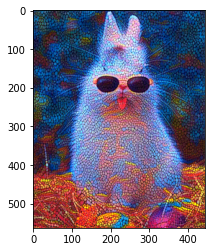

100%|██████████| 8/8 [08:54<00:00, 66.79s/it]

target ready!


In [13]:
# optim
lr = 1e-2

# iterations
steps = 2000
show_every = 100

targets = []
times = []

# load the content
content = Image.open(original_path)
size = content.size

# load the styles
styles_files = glob.glob(styles_path + '/*')
styles = [Image.open(f) for f in styles_files]

# run on all styles
print(f'running {steps} on {len(styles)} styles')
for style in tqdm(styles):
  start = time()

  target = transfer(content, style, vgg,
                    steps, show_every,
                    lr, size)

  targets.append(target)

  end = time() - start
  times.append(end)

### Let's see the results (and save them)

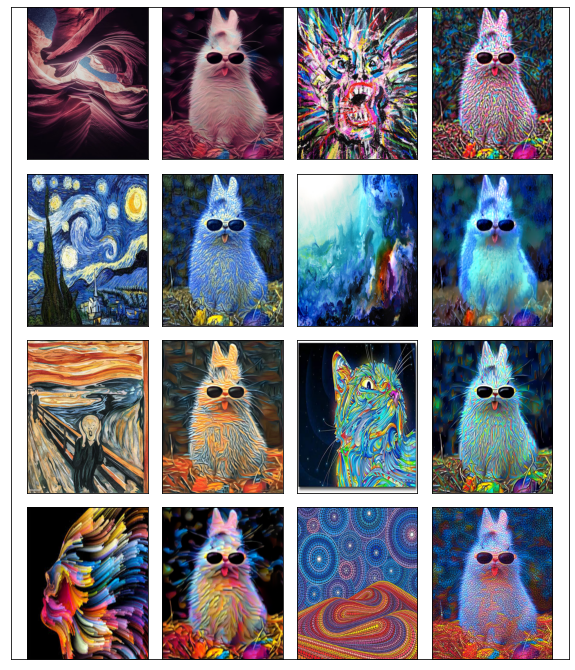

In [14]:
from mpl_toolkits.axes_grid1 import AxesGrid

F, ax = plt.subplots(figsize=(10, 12))
ax.grid(False)
grid = AxesGrid(F, 111, nrows_ncols=(int(len(styles)/2), 4), axes_pad=0.2)
ax.set_xticks([]);ax.set_yticks([])

j = 0
for i in range(len(styles)):
  st = styles[i].resize(size)
  res = targets[i]

  ax_0, ax_1 = grid[j], grid[j+1]
  j += 2

  ax_0.imshow(st); ax_0.set_xticks([]); ax_0.set_yticks([])
  ax_1.imshow(res); ax_1.set_xticks([]); ax_1.set_yticks([])

In [15]:
# how much time does this takes?

avg_time = np.average(np.array(times))
total_time = np.sum(np.array(times))
print(f'Total time: {(total_time/60):.2f} min.')
print(f'Average time per style: {avg_time:.2f} sec.')

Total time: 8.90 min.
Average time per style: 66.78 sec.


In [ ]:
F.savefig('/content/drive/My Drive/psychedelic_bunny_rabbit/results.png')

In [ ]:
if not os.path.isdir('/content/drive/My Drive/psychedelic_bunny_rabbit/targets'):
  os.mkdir('/content/drive/My Drive/psychedelic_bunny_rabbit/targets')

for i, res in enumerate(targets):
  cv2.imwrite(f'/content/drive/My Drive/psychedelic_bunny_rabbit/targets/target_0{i}.jpg', res*255)